## Import Libraries

In [1]:
import math, random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import os
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40)
from tqdm import tqdm
import matplotlib
import glob
import io
import base64
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 

from newenv import RLIAEnv 
import random

/home/adrian/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cuda

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## Building Environment

In this assignment, we will develope our agent playing CartPole, which is a classical environment in reinforcement learning. You may find more information about the environment [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

In [3]:
env = RLIAEnv() 

In [4]:
# In this part, we used depue object from collections in python to generate a buffer
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)                            # Initialization of the buffer of capacity given by the input of the function,' capacity'
    def push(self, state, action, reward, next_state, done):            # Store one single experience (state, action, reward, next_state, done flag) in the buffer
        state      = np.expand_dims(state, 0)                           # If you want to push an experience to the buffer, you have to make sure the 'state' and 'next_state' is 3-dimensional array
        next_state = np.expand_dims(next_state, 0)                      # 'action' and 'reward' are two scalars, the 'done' is 'False' or 'True'
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))    # This method will return you a batch of experiences
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    def __len__(self):                  
        return len(self.buffer)                       # This method return the length of the buffer

In [5]:
# define the buffer
replay_buffer = ReplayBuffer(1000)      # Here we define a buffer of capacity 1000, which means we will store at most 1000 newest experiences

<h2>Deep Q Network</h2>

Deep Q-Learning is a powerful extension of the Q-learning algorithm that replaces the traditional Q-table with a neural network. This network is designed to map input states to (action, Q-value) pairs, rather than simply storing the Q-values in a lookup table.

As illustrated in the figure below, the Q-network takes the current state as input and produces a set of Q-values, one for each possible action. The action with the highest Q-value is then selected as the next action during the exploitation phase of the algorithm.

This approach has several advantages over traditional Q-learning, including the ability to handle high-dimensional state spaces and to generalize from previously unseen states. However, it also introduces some additional complexity in terms of designing and training the neural network effectively.

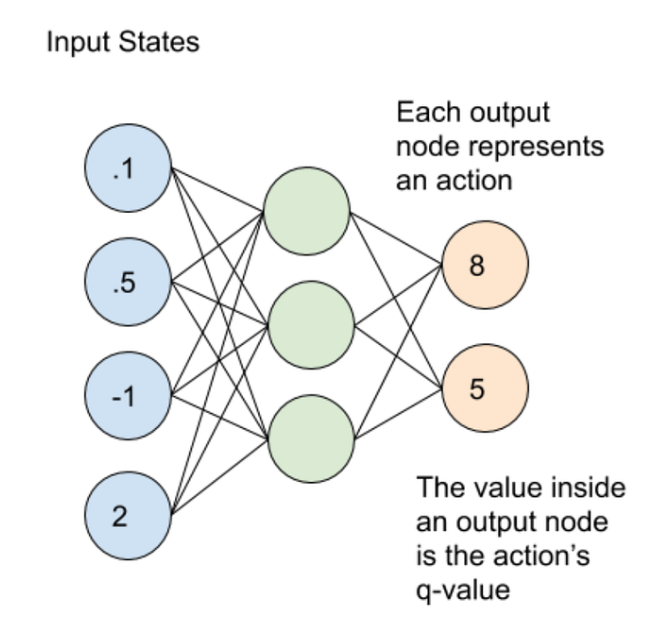

**Task 3:** Build a neural network mapping states to actions in the following blank. Attach screenshot of your code to your solution file. Check your result in test case and put the screenshot to your solution file.

You may find more information about the environment [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

In [6]:
# In this part, we are going to implement a quite basic neural network using pytorch. 
# The dimension and profile of the Q-network is crucial to the final performance, therefore we will provide some specific suggestions:
# Suggestions: 2-5 fully connected layers, less than 512 neurons per layer
# The training time, or say computational complexity directly depend on the scale of the network, which means you may want to find a balance between performance and complexity
class DQN(nn.Module):                                                         # We build our neural network using nn.Module class in pytorch, you may find some examples at https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(self, num_actions, num_states):                                          # 'num_action' is the number of all possible actions in the environment. Each action corresponds to one bit output of neural network. If we have 'num_action' actions, the output shape of the neural network should be 'num_action' by 1.
        super(DQN, self).__init__()
        ## student code here
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, num_actions))                                       # In this part, you need to define your network layer by layer, here is an great example showing how to implement: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
            
        ## student code end
    def forward(self, x):                                                     # With the network defined, we have to define the forwarding method for the neural network, within which input data will be forwarded in the order of your defined layers, and you need to return final output
        ## student code here
        if type(x) is not torch.Tensor:
            x = torch.tensor(x)
        y = self.layers(x.float())
                                          # define forward procedure of your network
        return y              # Return the output of the network. It should be the same dimension with action space 
        ## student code end


In [7]:
# WARNING: Due to the feature of ipython notebook, please rerun this cell before every time running main training cell, because we need to initialize the network before retraining it
eval_model = DQN(num_actions=env.action_space.n, num_states=4)
target_model  = DQN(num_actions=env.action_space.n, num_states=4)

if USE_CUDA:
    eval_model = eval_model.cuda()
    target_model  = target_model.cuda()

optimizer = optim.Adam(eval_model.parameters(), lr= 0.001)

In [8]:
# In this task, your are going to design epsilon-greedy policy. 
# The input of function the state and expected epsilon
# Epsilon is the probability of taking actions randomly
# Hint: you will compose to different strategies: taking action randomly & take action from Q-network; Every time you call this function with a certain epsilon, this function will choose one of the strategies with probability epsilon.
# Output: the output should be a integer, the index of the action in action space
def choose_action(state, epsilon):
    nmm =np.random.rand()
    print(nmm, epsilon, nmm<epsilon)
    state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True) 
    ## student code here
    if ( nmm< epsilon):
        print("EXPLOIT!")                                                          # We can implement exploiting here    
        q_value = eval_model.forward(state)                               # Use .forward() method in DQN class to get the Q values of all actions
        action = q_value.argmax().item()                 # Calculate the index of action with highest Q value. Hint: you can use torch.max()
        print(action)
    else:                                                                                 # We can implement exploring here
        action = np.random.randint(int(env.action_space.n), size=1)[0]   
        print("EXPLORE!")
        print(action)                    # You can use built-in functions in Random or Numpy to generate a action index randomly
    ## student code end
    return action                                                               # Return the index of action

In [9]:
# Test Case for Task 4
test_state = env.reset()
for i in range(10):                                       # We generate 10 actions using epsilon-greedy policy, epsilon = 0.5
    test_action = choose_action(test_state, 0.5)
    print('action ', i, 'is: ', test_action)

# The result of returned action should be an index in the range of action space's dimension. Here is an example:
# action  0 is:  1
# action  1 is:  0
# action  2 is:  1
# action  3 is:  0
# action  4 is:  1
# action  5 is:  1
# action  6 is:  1
# action  7 is:  1
# action  8 is:  0
# action  9 is:  1


0.26583350960440466 0.5 True
EXPLOIT!
2
action  0 is:  2
0.7894146014313996 0.5 False
EXPLORE!
1
action  1 is:  1
0.9969967608062158 0.5 False
EXPLORE!
1
action  2 is:  1
0.42204971064080743 0.5 True
EXPLOIT!
2
action  3 is:  2
0.037508316464131664 0.5 True
EXPLOIT!
2
action  4 is:  2
0.41266434672372687 0.5 True
EXPLOIT!
2
action  5 is:  2
0.18022140658418417 0.5 True
EXPLOIT!
2
action  6 is:  2
0.7412720733874693 0.5 False
EXPLORE!
2
action  7 is:  2
0.21681884223065206 0.5 True
EXPLOIT!
2
action  8 is:  2
0.9180172306726145 0.5 False
EXPLORE!
0
action  9 is:  0


In [10]:
# In this part, you will need to design a function that returns attenuated initial epsilon
# The input is the current training step. The bigger it is, the smaller the 'epsilon_current' should be.
# The output is the current epsilon of type 'float'
epsilon_initial = 1.0                # The epsilon should be 1 at the beginning        
## student code here
epsilon_by_frame = lambda x: pow((epsilon_initial - 0.001), x)    # Design your function here
## student code end

In [11]:
# In this part, we will calculate the temporal difference loss
# The input is batch size, which means we need to sample a group of experiences from the buffer and calculate a loss function value based on that batch
# In the expression above, we have shown you how to clculate one single loss for each experience. Given a batch of experience, all the variables are organized in high-dimensional array, within which the first dimension is the batch size.
# You can calculate the batch-organized varibles as usual, based on the expression above. Finally, you just need to put the calculated evaluate Q value and expected Q value into pytorch built-in MSE function, or calculate the final loss function value on your own.
def compute_td_loss(batch_size, gamma):
    state, action, reward, next_state, done = replay_buffer.sample(
        batch_size)  # Sample from buffer

    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))

    # Policy network.
    q_policy = eval_model(state)
    q_policy = q_policy.gather(1, action.unsqueeze(1)).squeeze(1)

    # Q values from the target network for the next state
    q_target_next = target_model(next_state)
    q_target_next = q_target_next.max(1)[0].detach()
    q_target = reward + gamma * (1 - done) * q_target_next

    # ## student code here (Note that we have provided some comments based on our implementation, but you do not have to follow them for yours.)
    # # If s_t is non-terminal state (done==Flase), we can follow steps below to calculate the loss:
    # q_values      =                                   # Calculate q values of using eval network with input 'state' using .forward() method
    # next_q_values =                                   # Calculate q values of using eval network with input 'next_state' using .forward() method
    # next_q_state_values =                             # Calculate q values of using target network with input 'next_state' using .forward() method

    # q_value       =         # select the eval q values of actions been played and stored at state s_t, this is the evaluate value
    # next_q_value =  # Use target network to calculate q values of actions that will be selected by eval network at state s_t+1, which is the second Q expression in the loss function above
    # expected_q_value =           # compute the expected value, which is the whole second component in MSE()

    loss_f = nn.MSELoss()
    loss = loss_f(q_policy, q_target)     # Calculate the loss
    # If s_t is terminal state (done==True), we need to calculate the loss using expression mentioned above
    # Calculate the loss
    # student code end
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


In [12]:
# In this part, we will update target network using the parameters from evaluate network
# The input is the evaluate network and target network
def update_target(eval_net, target_net):
    global eval_model
    global target_model
    ## student code here
    target_model.load_state_dict(eval_model.state_dict())
     # Hint: You may use nn.module.load_state_dict() to update parameters. More info:https://pytorch.org/tutorials/beginner/saving_loading_models.html
    ## student code end

In [13]:
# This function is defined to plot reward and loss curves
def plot(frame_idx, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [14]:
kind_experiment = { 
    0: "Random",
    1: "MAB",
    2: "DDQN",
}

chosen_strategy = { 
    0: "9x9",
    1: "25x25",
    2: "Exaustive search",
}

def appendToDf(df, type, ts_begin, ts_end, spectral_efficiency, episode, reward, strategy, distance):
    df.loc[len(df)] = [type, kind_experiment[type],ts_begin, ts_end, ts_end-ts_begin, spectral_efficiency, episode, reward, strategy, chosen_strategy[strategy], distance]



measurements = pd.DataFrame(columns=["type",  "type_str",
                  "ts_begin", "ts_end", "ts_diff", "spectral_efficiency", "episode", "reward", "strategy", "strategy_str", "distance"])



<h2>Training</h2>

**Task 8:** pick batch size, gamma, NETWORK_UPDATE_PERIOD, learning rate and other hyperparameters to train the agent. Report result in your solution file and give your conclusions. Go over the training procedure carefully, and write down corresponding pseudo code in your solution file.

**WARNING**: Please rerun previous "Evaluate Network and Target Network" cell before rerun this main training cell

In [15]:
# Below is the main training procedure of deep Q-learning
# Please go over each line and tune the hyperparameters for satisfied performance
replay_buffer = ReplayBuffer(1000)  # clear the buffer
# student code here
num_frames = 10000                        # Suggested range: 2000 - 10000
batch_size = 64                           # Suggested range: 8 - 128
GAMMA = 0.9                      # Suggested range: >0.9
NETWORK_UPDATE_PERIOD = 50        # Suggested range: 50 - 300
# student code end

episodes = 10000
losses = []
all_rewards = []
episode_reward = 0

beam9stren = []
beam25stren = []
beamexhaustivestren = []

actions = ["9beam", "25beam", "exhaustive"]

state = env.reset()
for i in range(episodes):
    #epsilon = epsilon_by_frame(i)
    epsilon = 0.7
    print("epsilon: ", epsilon)
    print(env.ue_loc)
    action = choose_action(state, epsilon)                  # pick action
    next_state, reward, done, _ = env.step(
        action)          # interact with environment
    replay_buffer.push(state, action, reward, next_state,
                    done)  # store experience
    state = next_state
    episode_reward += reward
    if len(replay_buffer) > batch_size:                             # start training
        loss = compute_td_loss(batch_size, GAMMA)
        losses.append(loss.cpu().data.numpy())
    # update target network using eval network
    if i % NETWORK_UPDATE_PERIOD == 0:
        update_target(eval_model, target_model)


epsilon:  0.7
[15, -6]
0.5424273904391894 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.9000161958033842 0.7 False
EXPLORE!
2
epsilon:  0.7
[15, -6]
0.6892534844581131 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.0366951335467649 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.9715834415599683 0.7 False
EXPLORE!
1
epsilon:  0.7
[15, -6]
0.24582627632295007 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.7422375437548565 0.7 False
EXPLORE!
0
epsilon:  0.7
[15, -6]
0.39821854707068793 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.4546782451233322 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.5719822975429115 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.4820555311247252 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -6]
0.6669444703558431 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -5]
0.04453571234886733 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -5]
0.7906299957803463 0.7 False
EXPLORE!
0
epsilon:  0.7
[15, -5]
0.5504336050549007 0.7 True
EXPLOIT!
2
epsilon:  0.7
[15, -5]
0.3742275628911068 0.7 True
EXPLOIT!
2
e

In [16]:
# testing
epinum = 0
state = env.reset()
type_measurement = 2
print('TESTING')
for i in range(4000):
    ts_begin = time.process_time()
    q_value = target_model.forward(state)                               # Use .forward() method in DQN class to get the Q values of all actions
    action = q_value.argmax().item()      
    # action = choose_action(state, 1)
    state, reward, done, _ = env.step(action)
    print("action: ", actions[action])
    print("reward: ", reward)
    print("uecloc: ", env.ue_loc)
    print("\n                       ")
    ts_end = time.process_time()
    epinum = epinum+1
    appendToDf(df=measurements, type=type_measurement,ts_begin=ts_begin, ts_end=ts_end, spectral_efficiency=state[0], episode = epinum, reward=reward, strategy=int(action), distance=state[3])
    
env.close()

TESTING
action:  exhaustive
reward:  9.031269091692026
uecloc:  [15, -5]

                       
action:  exhaustive
reward:  9.031269091692026
uecloc:  [15, -5]

                       
action:  exhaustive
reward:  9.031269091692026
uecloc:  [15, -5]

                       
action:  exhaustive
reward:  9.031269091692026
uecloc:  [15, -5]

                       
action:  exhaustive
reward:  9.031269091692026
uecloc:  [15, -5]

                       
action:  exhaustive
reward:  9.031269091692026
uecloc:  [15, -5]

                       
action:  exhaustive
reward:  9.031269091692026
uecloc:  [15, -5]

                       
action:  exhaustive
reward:  9.211324182766676
uecloc:  [15, -4]

                       
action:  exhaustive
reward:  9.211324182766676
uecloc:  [15, -4]

                       
action:  exhaustive
reward:  9.211324182766676
uecloc:  [15, -4]

                       
action:  exhaustive
reward:  9.211324182766676
uecloc:  [15, -4]

                       
ac

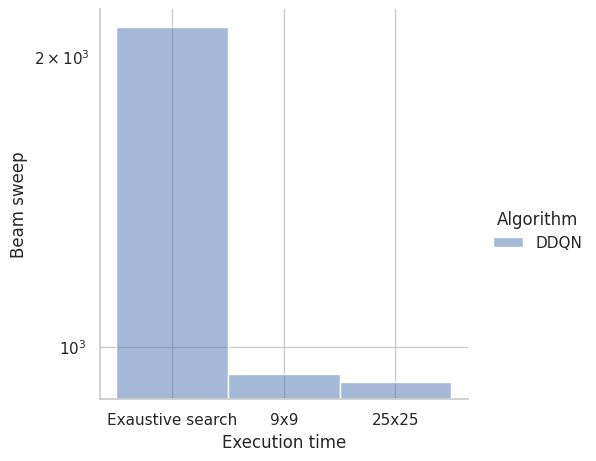

In [17]:
sns.set(style="whitegrid")
g = sns.displot(data=measurements, x="strategy_str", hue="type_str", col="type_str", log_scale=(False, True))
g.set(ylabel="Beam sweep", xlabel="Execution time", title="")
g.legend.set_title("Algorithm")

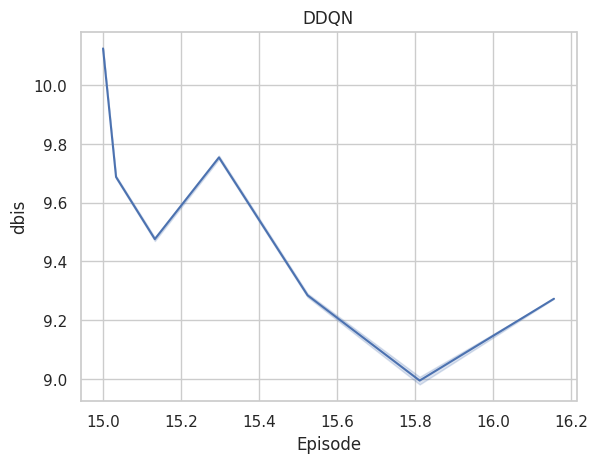

In [18]:
g = sns.lineplot(data=measurements,x="distance", y="reward")
g.set(ylabel="dbis", xlabel="Episode", title="DDQN")
plt.show(g)

**Task 9:** After implementing the double DQN, we are interested in hearing about any interesting findings or observations you may have made. This could include insights into key hyperparameters, effective improving mechanisms, or any other subject that you found particularly interesting.

To receive full credit for this open-ended question, we ask that you provide a detailed discussion supported by persuasive data or experimental results. This could include comparisons between different hyperparameters, experiments demonstrating the effectiveness of specific techniques, or analyses of the impact of different factors on the performance of the model.